# "Quantum" Keyword Example

## General Project Description:
This project makes use of the Arxive API. Arxive is an online database of research papers.

The idea of this project is to use a keyword to find related articles. The pipeline is as follows:
1. User inputs an inital keyword.
2. The program makes a call to the Arxive API and takes some articles, storing their titles, authors, date, and link in a pandas dataframe.
3. We use Google Gemini to determine related keywords, noting which keywords are associated with which article. Google gemini also creates a similarity score between articles. 
4. We use a cosine similiarty score to combine keywords. For example, we would want to combine "computer" and "computers" since they are essentially the same word. The actual score threshold can be set by the user.
5. The program iterates on each keyword to find more articles. The Arxive API is called again (with the new keyword) and articles are
taken. Steps 3 to 4 are repeated until either every keyword has been searched through or a user decided number has been reached (that is, the user can say only search through the first three keywords, for example).
6. Using Gemini's similairty score, create pairs of papers and assign a similarity score between them. This is stored in a dataframe with the columns "paper 1", "paper 2", and "score"
7. Using this dataframe, we create and display a graph using the "score" column as edge weights between papers.

The main function, `find_similar_papers`, returns a list of all the keywords, a dataframe of all the papers (with their authors, links, and dates), and the dataframe form of the graph. This allows the user to pick whatever mode is most convient for them to search through/look at the papers and their relatedness.

Most of the functions used in this program are in the `Embed.py` file under the `Embed` class.

## This Notebook:
The following script is an example usage of this program. It uses the keyword "quantum". It goes through exaclty the process described above.

In [1]:
import os
from google import genai
import ArxivQuery as aq
import Embed as eb
from queue import Queue
import pandas as pd

In [3]:
api_key = os.getenv("api_key")

def keyword_dict_merge(dict1, dict2):
    merged = {}
    all_keys = set(dict1) | set(dict2)

    for key in all_keys:
        combined_scores = {}
        for d in (dict1, dict2):
            if key in d:
                for idx, score in d[key]:
                    if idx in combined_scores:
                        combined_scores[idx] = max(combined_scores[idx], score)
                    else:
                        combined_scores[idx] = score
        merged[key] = [(idx, score) for idx, score in combined_scores.items()]
    return merged

def find_similar_papers(keyword, api_key, paper_n=3, rounds=2, similiarity_threshold=0.75, q_size=5):
    client = genai.Client(api_key=api_key)
    emb = eb.Embed(client, similiarity_threshold)
    df = pd.DataFrame(columns=['title', 'summary', 'published', 'authors', 'link'])

    query = aq.ArxivQuery(keyword, paper_n)
    query.df = query.df.reset_index(drop=True)
    df = pd.concat([df, query.df], ignore_index=True)

    keywords = emb.extract_keywords(query.df)
    all_keywords = {}

    for key, values in keywords.items():
        all_keywords[key] = [(int(idx), score) for idx, score in values]

    q = Queue()
    seen_terms = set()

    for i in range(rounds):
        for term in keywords:
            if term not in seen_terms:
                q.put(term)
                seen_terms.add(term)

        j = 0
        while j < q_size:
            if q.empty():
                break

            new_term = q.get()
            query = aq.ArxivQuery(new_term, paper_n)
            qdf = query.df.reset_index(drop=True)
            start_idx = len(df)
            df = pd.concat([df, qdf], ignore_index=True)
            keywords = emb.extract_keywords(qdf)
            shifted_keywords = {}
            for key, values in keywords.items():
                shifted_keywords[key] = [(start_idx + int(idx), score) for idx, score in values]
            all_keywords = keyword_dict_merge(all_keywords, shifted_keywords)
            j += 1

    linked_papers = emb.link_papers(df, all_keywords)
    G = emb.build_graph_from_links(linked_papers)
    emb.display_graph_with_weights(G)
    return G, all_keywords, df


quantum grammars
(0, 0.9) (3, 0.9)
(0, 0.9) (6, 0.9)
(3, 0.9) (6, 0.9)
quantum assembly language
(0, 0.8) (1, 0.8)
quantum state
(12, 0.9) (20, 0.8)
quantum Turing Machine
(9, 0.9) (10, 0.9)
(9, 0.9) (11, 0.9)
(10, 0.9) (11, 0.9)
quantum states
(1, 0.9) (17, 0.9)
(1, 0.9) (23, 0.7)
(1, 0.9) (32, 0.9)
(17, 0.9) (23, 0.7)
(17, 0.9) (32, 0.9)
(23, 0.7) (32, 0.9)
spin squeezing
(17, 0.8) (32, 0.7)
class complexity
(24, 0.9) (25, 0.9)
quantum assembly
(3, 0.7) (6, 0.7)
(3, 0.7) (7, 0.7)
(3, 0.7) (8, 0.9)
(6, 0.7) (7, 0.7)
(6, 0.7) (8, 0.9)
(7, 0.7) (8, 0.9)
multipartite entanglement
(15, 0.95) (27, 0.8)
(15, 0.95) (28, 0.9)
(15, 0.95) (29, 0.9)
(15, 0.95) (30, 0.95)
(27, 0.8) (28, 0.9)
(27, 0.8) (29, 0.9)
(27, 0.8) (30, 0.95)
(28, 0.9) (29, 0.9)
(28, 0.9) (30, 0.95)
(29, 0.9) (30, 0.95)
symmetric states
(1, 0.7) (12, 0.7)
ground state
(16, 0.8) (31, 0.8)
quantum complexity
(2, 0.95) (18, 0.9)
(2, 0.95) (20, 0.9)
(18, 0.9) (20, 0.9)
symmetric state
(15, 0.9) (16, 0.9)
(15, 0.9) (30, 0.85)
(1

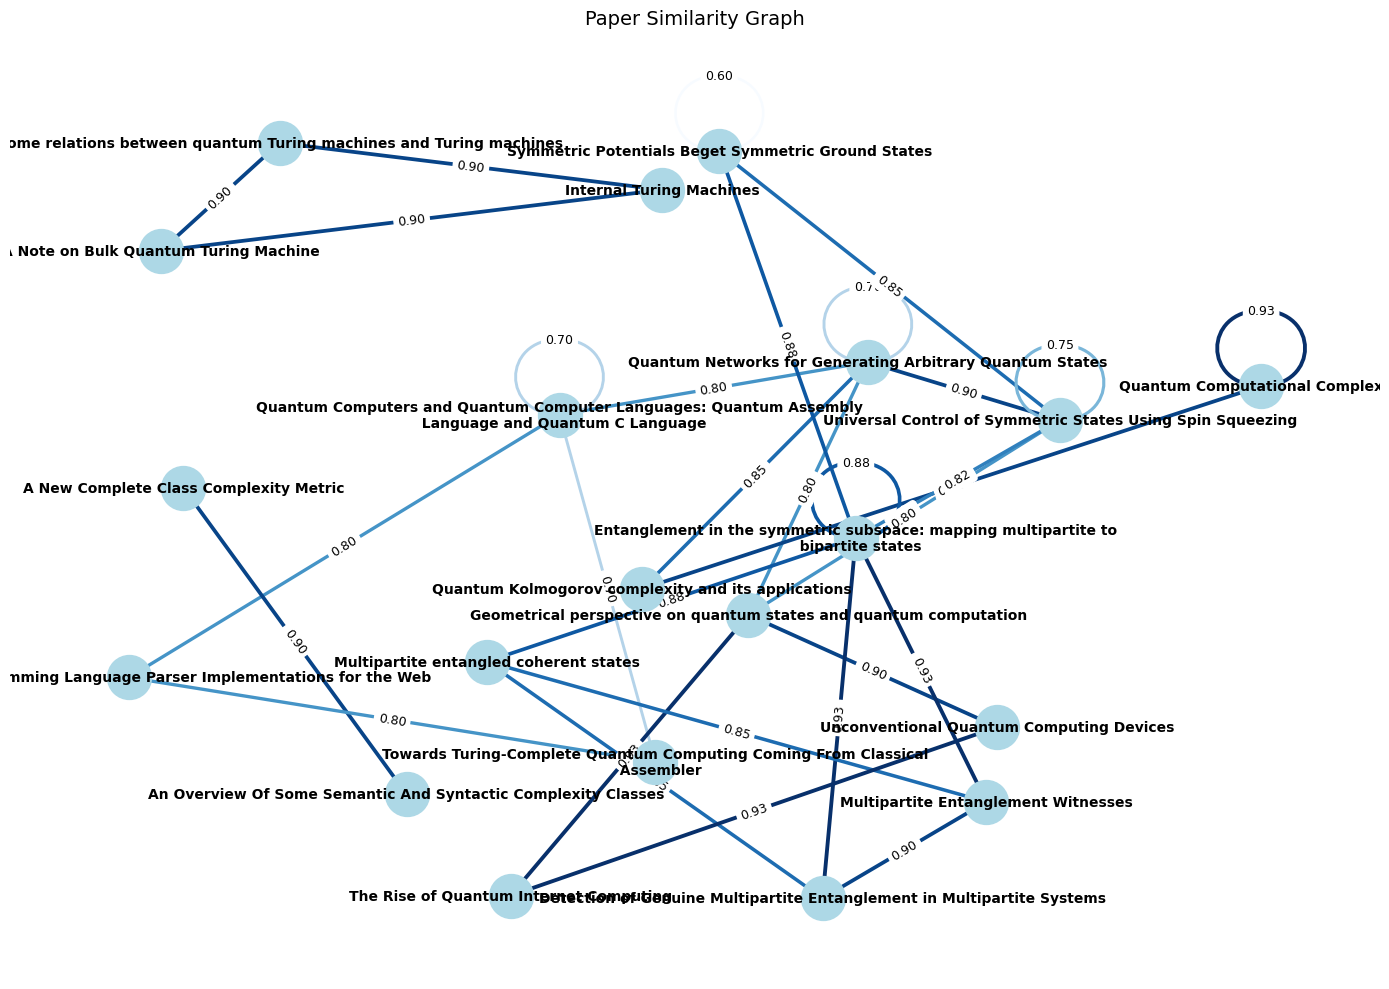

In [4]:
G, all_keywords, df = find_similar_papers("quantum", api_key, paper_n = 3, similiarity_threshold = 0.75)

quantum complexity
(2, 0.9) (18, 0.9)
(2, 0.9) (20, 0.95)
(18, 0.9) (20, 0.95)
symmetric states
(1, 0.7) (9, 0.7)
quantum algorithm
(1, 0.8) (2, 0.8)
(1, 0.8) (9, 0.8)
(1, 0.8) (11, 0.9)
(1, 0.8) (12, 0.9)
(1, 0.8) (13, 0.9)
(1, 0.8) (14, 0.95)
(2, 0.8) (9, 0.8)
(2, 0.8) (11, 0.9)
(2, 0.8) (12, 0.9)
(2, 0.8) (13, 0.9)
(2, 0.8) (14, 0.95)
(9, 0.8) (11, 0.9)
(9, 0.8) (12, 0.9)
(9, 0.8) (13, 0.9)
(9, 0.8) (14, 0.95)
(11, 0.9) (12, 0.9)
(11, 0.9) (13, 0.9)
(11, 0.9) (14, 0.95)
(12, 0.9) (13, 0.9)
(12, 0.9) (14, 0.95)
(13, 0.9) (14, 0.95)
proof systems
(21, 0.8) (22, 0.8)
quantum computation
(18, 0.8) (20, 0.7)
quantum grammars
(0, 0.9) (3, 0.9)
(0, 0.9) (6, 0.9)
(3, 0.9) (6, 0.9)
spin squeezing
(17, 0.7) (29, 0.7)
potentials
(16, 0.7) (28, 0.6)
ground states
(30, 0.8) (31, 0.9)
(30, 0.8) (32, 0.7)
(31, 0.9) (32, 0.7)
multipartite entanglement
(15, 0.95) (24, 0.8)
(15, 0.95) (25, 0.95)
(15, 0.95) (26, 0.9)
(15, 0.95) (27, 0.95)
(24, 0.8) (25, 0.95)
(24, 0.8) (26, 0.9)
(24, 0.8) (27, 0.95)
(

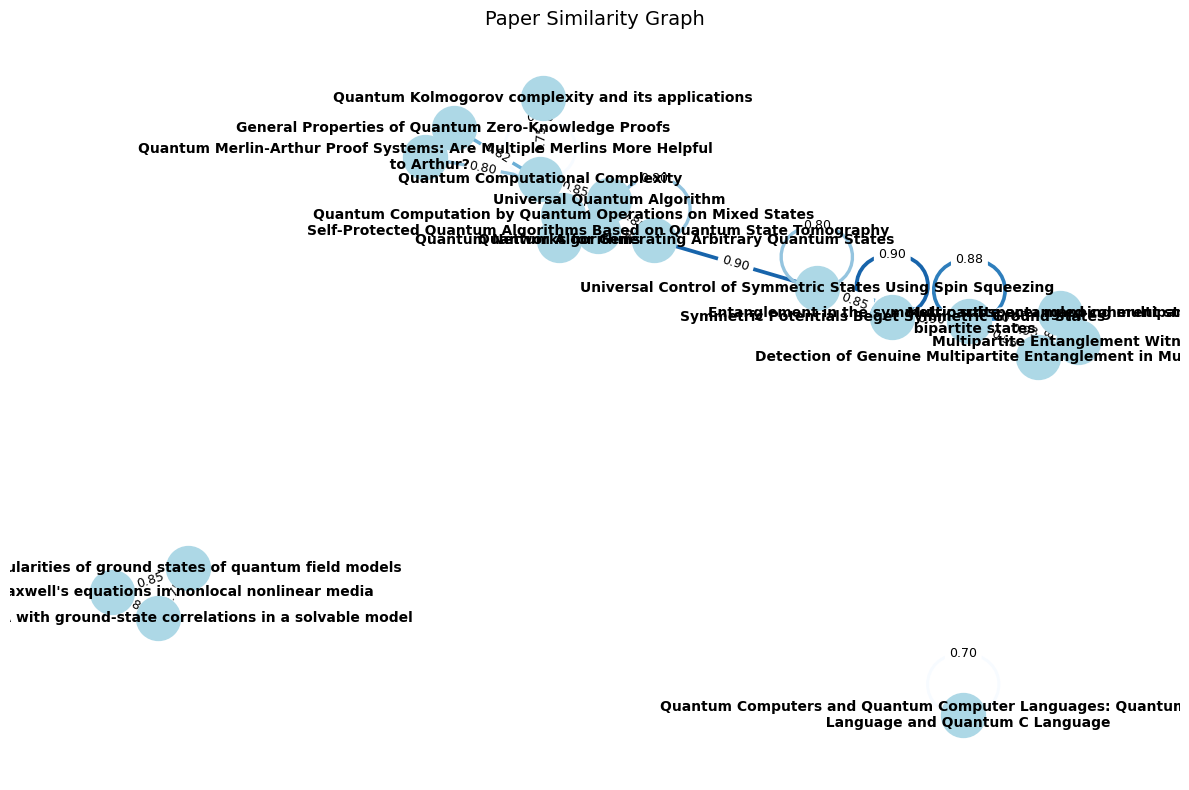

quantum complexity
(2, 0.9) (18, 0.9)
(2, 0.9) (20, 0.95)
(18, 0.9) (20, 0.95)
symmetric states
(1, 0.7) (9, 0.7)
quantum algorithm
(1, 0.8) (2, 0.8)
(1, 0.8) (9, 0.8)
(1, 0.8) (11, 0.9)
(1, 0.8) (12, 0.9)
(1, 0.8) (13, 0.9)
(1, 0.8) (14, 0.95)
(2, 0.8) (9, 0.8)
(2, 0.8) (11, 0.9)
(2, 0.8) (12, 0.9)
(2, 0.8) (13, 0.9)
(2, 0.8) (14, 0.95)
(9, 0.8) (11, 0.9)
(9, 0.8) (12, 0.9)
(9, 0.8) (13, 0.9)
(9, 0.8) (14, 0.95)
(11, 0.9) (12, 0.9)
(11, 0.9) (13, 0.9)
(11, 0.9) (14, 0.95)
(12, 0.9) (13, 0.9)
(12, 0.9) (14, 0.95)
(13, 0.9) (14, 0.95)
proof systems
(21, 0.8) (22, 0.8)
quantum computation
(18, 0.8) (20, 0.7)
quantum grammars
(0, 0.9) (3, 0.9)
(0, 0.9) (6, 0.9)
(3, 0.9) (6, 0.9)
spin squeezing
(17, 0.7) (29, 0.7)
potentials
(16, 0.7) (28, 0.6)
ground states
(30, 0.8) (31, 0.9)
(30, 0.8) (32, 0.7)
(31, 0.9) (32, 0.7)
multipartite entanglement
(15, 0.95) (24, 0.8)
(15, 0.95) (25, 0.95)
(15, 0.95) (26, 0.9)
(15, 0.95) (27, 0.95)
(24, 0.8) (25, 0.95)
(24, 0.8) (26, 0.9)
(24, 0.8) (27, 0.95)
(

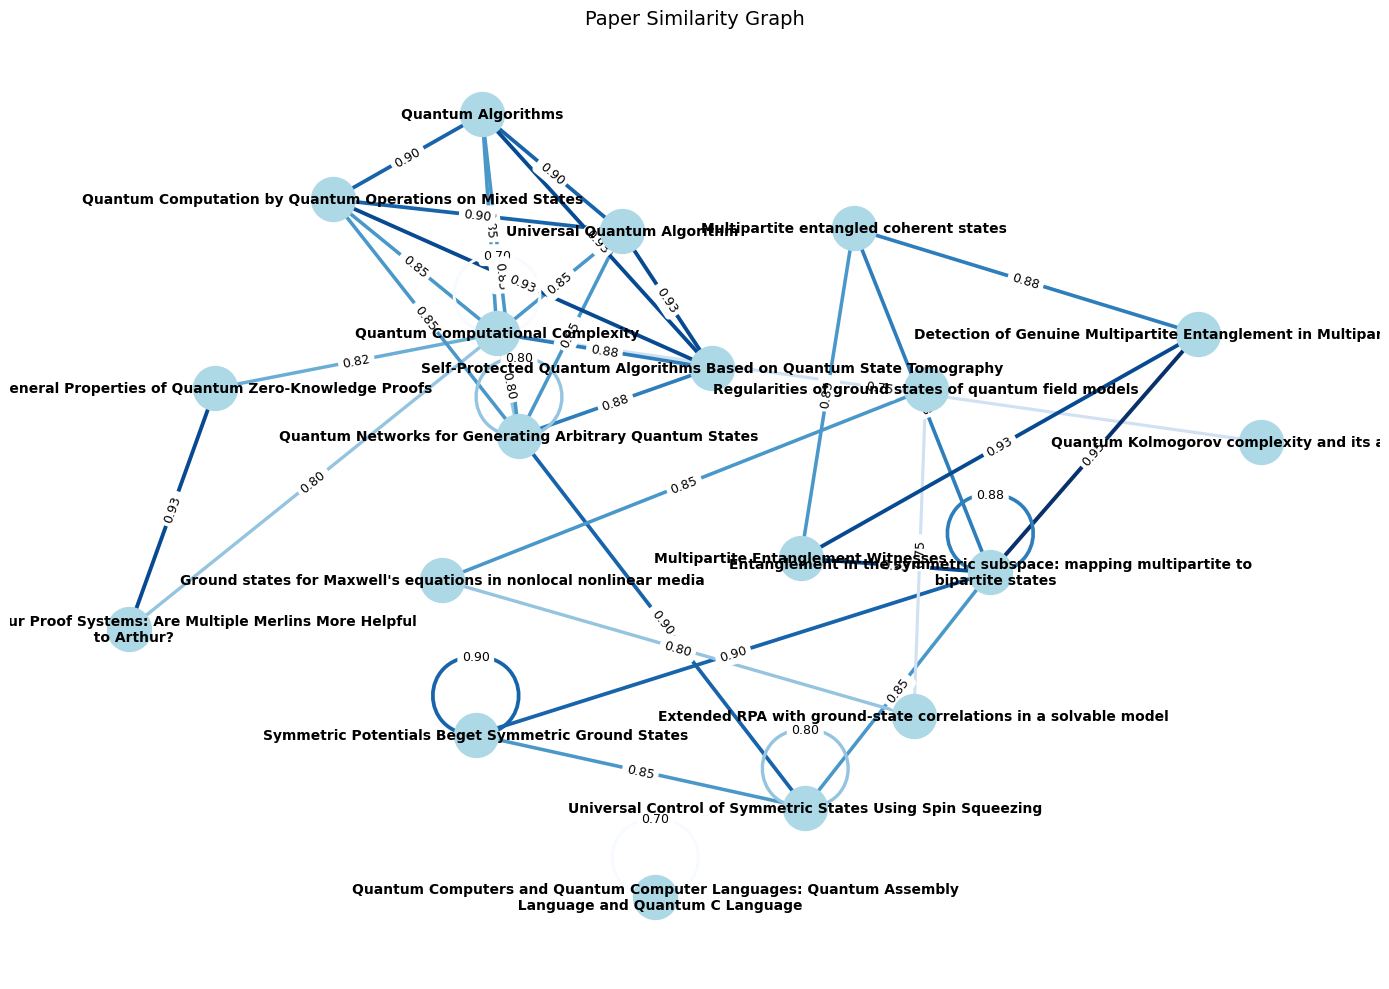

In [ ]:
client = genai.Client(api_key = api_key)
emb = eb.Embed(client, 0.75)

import networkx as nx
import matplotlib.pyplot as plt

linked_papers = emb.link_papers(df, all_keywords)
G = emb.build_graph_from_links(linked_papers)
emb.display_graph_with_weights(G)








,title,summary,published,authors,link
0,Quantum Computers and Quantum Computer Languag...,We show a representation of Quantum Computers ...,2002,[Stephen Blaha],http://arxiv.org/abs/quant-ph/0201082v1
1,Quantum Networks for Generating Arbitrary Quan...,Quantum protocols often require the generation...,2004,"[Phillip Kaye, Michele Mosca]",http://arxiv.org/abs/quant-ph/0407102v1
2,Quantum Computational Complexity,This article surveys quantum computational com...,2008,[John Watrous],http://arxiv.org/abs/0804.3401v1
3,Geometrical perspective on quantum states and ...,We interpret quantum computing as a geometric ...,2013,[Zeqian Chen],http://arxiv.org/abs/1311.4939v1
4,Universal Quantum Algorithm,Quantum amplitude amplification and quantum ph...,2016,[Avatar Tulsi],http://arxiv.org/abs/1611.03472v1
5,Quantum Grothendieck polynomials,We study the algebraic aspects of (small) quan...,1996,[Anatol N. Kirillov],http://arxiv.org/abs/q-alg/9610034v1
6,Nonlinear Dynamics In Quantum Physics -- Quant...,We discuss the recently proposed quantum actio...,2003,[H. Kröger],http://arxiv.org/abs/quant-ph/0302169v1
7,Lecture Notes on Quantum Algorithms in Open Qu...,These lecture notes aim to provide a clear and...,2024,[Matteo Carlesso],http://arxiv.org/abs/2406.11613v1
8,From quantum graphs to quantum random walks,We give a short overview over recent developme...,2005,[Gregor Tanner],http://arxiv.org/abs/quant-ph/0504224v1
9,Quantum Metamaterials: Applications in quantum...,Metamaterials are artificially engineered peri...,2020,"[Solomon Uriri, Yaseera Ismail, Francesco Petr...",http://arxiv.org/abs/2006.03757v1


In [8]:
import numpy as np

def _embed_word(word, client):
        response = client.models.embed_content(
            model="gemini-embedding-exp-03-07",
            contents=word
        )
        return response.model_dump()["embeddings"][0]['values']

def _cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [9]:
client = genai.Client(api_key = api_key)
word1 = _embed_word("quantum computer", client)
word2 = _embed_word("quantum computation", client)

_cosine_similarity(word1, word2)

np.float64(0.8439404828905617)